# TensorBoard 실행하기
- CIFAR10 데이터셋 이용해서 TensorBoard 활용해보기

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [35]:
class Net(nn.Module):
    def __init__(self): 
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(20 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
trainsets = torchvision.datasets.CIFAR10(root = '../data', train = True,
                                           download = False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainsets, batch_size = 128,
                                          shuffle=True, num_workers = 1)

classes = trainsets.classes
print(trainsets)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()


deer deer airplane airplane


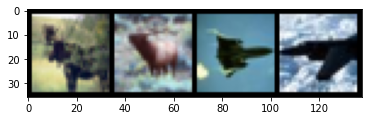

In [37]:
def imshow(img):
    img_grid = torchvision.utils.make_grid(img)
    plt.imshow(img_grid.permute((1,2,0)))
    
example_data = iter(trainloader).next()
example_images, example_labels = example_data

imshow(example_images[:4])
print(' '.join(classes[i] for i in example_labels[:4]))

In [38]:
# Tensorboard
from torch.utils.tensorboard import SummaryWriter

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [40]:
batch_sizes = [2, 64, 128]
learning_rates = [0.1, 0.01, 0.001]

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        step = 0
        
        # 네트워크 초기화
        model = Net()
        model.to(device)
        model.train()
        trainloader = torch.utils.data.DataLoader(trainsets, batch_size=batch_size, shuffle=True)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        loss_func = nn.CrossEntropyLoss()
        writer = SummaryWriter(f'runs/CIFAR/MiniBatchSize {batch_size} LR {learning_rate}') 
        
        for epoch in range(1):
            losses = []
            accuracy = []

            for idx, (images, labels) in enumerate(trainloader):
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = loss_func(output, labels)
                losses.append(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predictions = output.max(1)
                num_correct = (predictions == labels).sum()
                running_train_acc = num_correct/images.shape[0]
                accuracy.append(running_train_acc)
                
                # tensorboard
                writer.add_scalar('Traing Loss', loss, global_step=step)
                writer.add_scalar('Training Accuracy', running_train_acc, global_step=step)
                step += 1
                
            writer.add_hparams({'Lr': learning_rate, 'bsize': batch_size,},
                               {'accuracy': sum(accuracy)/len(accuracy),
                                'Loss': sum(losses)/len(losses)})

            print(f'MiniBatchSize {batch_size} LR {learning_rate} Loss : {sum(losses)/len(losses):.4}')

MiniBatchSize 2 LR 0.1 Loss : 2.156
MiniBatchSize 2 LR 0.01 Loss : 1.726
MiniBatchSize 2 LR 0.001 Loss : 2.237
MiniBatchSize 64 LR 0.1 Loss : 2.051
MiniBatchSize 64 LR 0.01 Loss : 2.302
MiniBatchSize 64 LR 0.001 Loss : 2.304
MiniBatchSize 128 LR 0.1 Loss : 2.152
MiniBatchSize 128 LR 0.01 Loss : 2.302
MiniBatchSize 128 LR 0.001 Loss : 2.305
